# Consumer Loans

It may be possible to predict the default probability of consumer loans and investigate which variables specific to the loan is a significant predictor. In addition, we may be able to determine the value of a consumer if they have defaulted. We therefore have two tasks: determine which variables have the most significant impact on default probability; obtain a model for the value of a consumer once they have defaulted.

For variable significance and variable selection, we can start with a linear model. But first we explore the data once we have imported the necessary libraries.

## Import Libraries

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import statistics
import datetime
import matplotlib
%matplotlib inline

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix

C:\Users\HVAD\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
# Get Versions
print('Python Version = {}'.format(sys.version[0:31]))
print('Numpy Version = {}'.format(np.__version__))
print('Pandas Version = {}'.format(pd.__version__))
print('Matplotlib Version = {}'.format(matplotlib.__version__))
print('Seaborn Version = {}'.format(sns.__version__))
print('sklearn Version = {}'.format(sklearn.__version__))

Python Version = 3.6.4 |Anaconda custom (64-bit)
Numpy Version = 1.14.0
Pandas Version = 0.22.0
Matplotlib Version = 2.1.2
Seaborn Version = 0.8.1
sklearn Version = 0.19.1


## The Loans Dataset

First we read in the excel sheets and write to csv as a 1-time action since reading from CSV is quicker in subsequent notebook startups.

In [4]:
if((not os.path.isfile('Performance.csv')) or (not os.path.isfile('StaticData.csv'))):
    StaticData = pd.read_excel('LoansDataset.xlsx',sheet_name='Static Data')
    Performance = pd.read_excel('LoansDataset.xlsx',sheet_name='Performance',header=1)

    # Note that here, all NA values are converted to null or empty
    StaticData.to_csv('StaticData.csv',index=False)
    Performance.to_csv('Performance.csv',index=False)

In [5]:
StaticData = pd.read_csv('StaticData.csv',low_memory=False)
Performance = pd.read_csv('Performance.csv',low_memory=False)

We can see below that there are 72167 records. The LoanID is viable for use as a unique index since we see that there are 72167 unique values for this column. This also means that we can merge the StaticData DataFrame with the Performance DataFrame on LoanID and not generate multiple records.

In [6]:
StaticData.info()

print()
print()

print('The number of unique entries for LoanID in the StaticData DataFrame is {}'.format(StaticData['LoanID'].nunique()))

print()
print()

print('The number of unique entries for LoanID in the Performance DataFrame is {}'.format(Performance['LoanID'].nunique()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72167 entries, 0 to 72166
Data columns (total 20 columns):
Year                             72167 non-null int64
LoanID                           72167 non-null int64
Original Loan Size               72167 non-null float64
Origination Date                 72167 non-null object
Original Term                    72167 non-null int64
APR                              72167 non-null float64
Loan Rate                        72167 non-null float64
LTV                              72167 non-null float64
Monthly Instalment               72167 non-null float64
Type 1                           72167 non-null object
Type 2                           72167 non-null object
Borrower's Employment Status     72167 non-null object
Risk Tier                        72167 non-null object
Exposure At Default              3168 non-null float64
Further Recovery Expected Y/N    3168 non-null object
Recoveries @ 6m                  1801 non-null float64
Recoveries

Here's the distribution of loans accross years

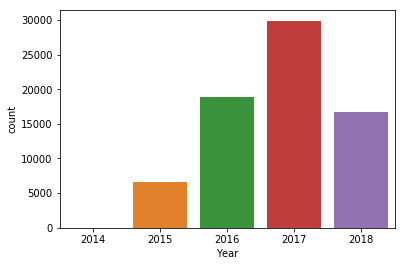

In [7]:
sns.countplot(x="Year",data=StaticData)

It seems that most loans are dated in 2017. Additionally, *Employed* consumers take/are given loans the most regardless of the year.

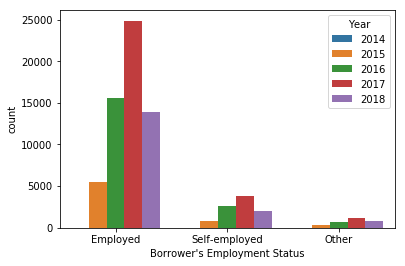

In [8]:
sns.countplot(x="Borrower's Employment Status",hue='Year',data=StaticData)

We merge the Performance DataFrame with the StaticData DataFrame to obtain performance information for each loan

In [9]:
# ACTION: Merge
MergedData = StaticData.merge(Performance.iloc[:,0:3],on='LoanID')

What does default within the first 24 months actually mean? We will have to give a specific definition and the definition we give here is 'All cases with default within the first 12 months is a subset of all cases with default within the first 24 months'. We can see below that there is some ambiguity in the *Status 24* column. Specifically, there are 709 cases where there has been a default within the first 12 months but we have 'NA' in the *Status 24* column.

In [10]:
len(MergedData[(MergedData['Status 12'] == 1) & (MergedData['Status 24'] != 1)])

709

We therefore create a new column called *Default 24* which caters for this. Below we see that there are no longer any cases that allow for a default within the first 12 months but 'NA' in the first 24 months. We also make sure that in cases where there is no default within 12 months, and the *Status 24* column has 'NA' that there is no default within 24 months also.

In [44]:
# ACTION: Create new Default24 column and use this instead in the models

def default24(x):
    '''
    This function is used in the creation of the Default24 column in accordance with the definition we use here.
    x := A row of a DataFrame with x[0], x[1] the 'Status 12' and 'Status 24' columns respectively.
    The logic is: If Status 12 = 1, then Default24 = 1. If Status 12 = 0 and Status 24 = NA, then Default24 = 0,
    otherwise, Default24 = Status 24.
    '''
    if x[0] == 1:
        return 1
    elif x[0] == 0 and np.isnan(x[1]):
        return 0
    else:
        return x[1]
    


In [46]:
# Create a new column dependent on whether there has been a default within the first 12 months
MergedData['Default24'] = MergedData[['Status 12','Status 24']].apply(lambda x: default24(x),axis=1)
print('There are {} cases of ambiguity with the \'Default24\' column'.format(len(MergedData[(MergedData['Status 12'] == 1) & (MergedData['Default24'] != 1)])))

There are 0 cases of ambiguity with the 'Default24' column


We can see that in proportion to the total number of loans, there are very few that have defaulted:

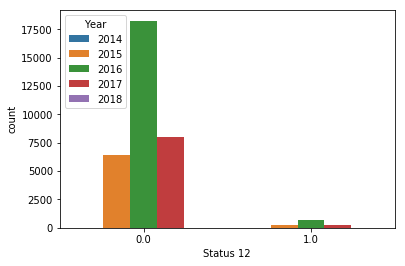

In [12]:
sns.countplot(x="Status 12",hue='Year',data=MergedData)

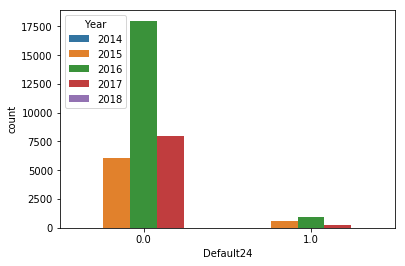

In [13]:
sns.countplot(x="Default24",hue='Year',data=MergedData)

#### Default Probability

It seems that except for year 2014 for which there was no default information, the average *Loan Rate* for those that didn't default is slightly lower than for those that did default. This holds true for both the 12 month and 24 month periods. This suggests that the *Loan Rate* can give us some information as to the probability of default:

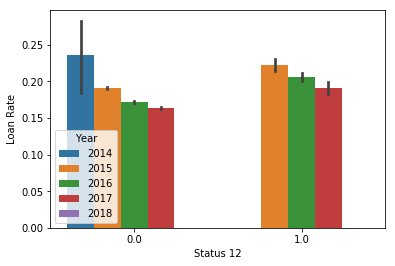

In [14]:
# ACTION: Add loan rate to the model parameters
sns.barplot(x="Status 12",y='Loan Rate',hue='Year',data=MergedData)

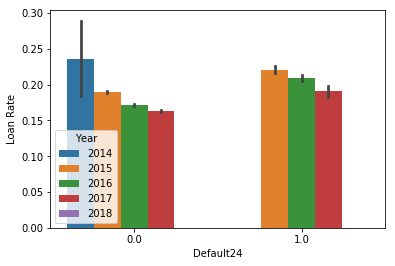

In [15]:
sns.barplot(x="Default24",y='Loan Rate',hue='Year',data=MergedData)

Consumers that default have a consistently larger Original Loan Size on average each year. This may also be an indicator of default:

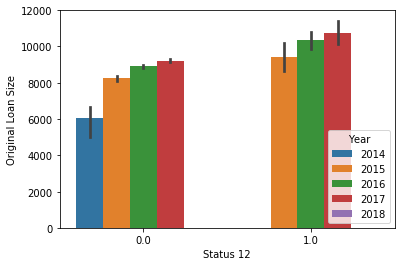

In [16]:
# ACTION: Add Original Loan Size to the model parameters
sns.barplot(x="Status 12",y='Original Loan Size',hue='Year',data=MergedData)

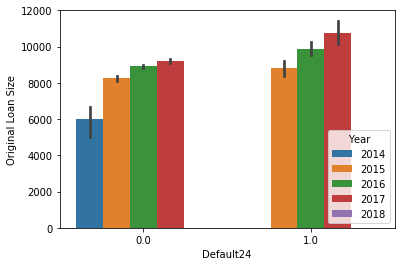

In [17]:
sns.barplot(x="Default24",y='Original Loan Size',hue='Year',data=MergedData)

Let's see if *Employment Status* is any indication for default. We can't just do a count plot since we know that more Employed Consumers take out loans. So we find the ratio of default in each category by grouping on *Borrower's Employment Status*. We see that whether a consumer is *Self-employed*, *Employed* or *Other* has an effect on the default probability:

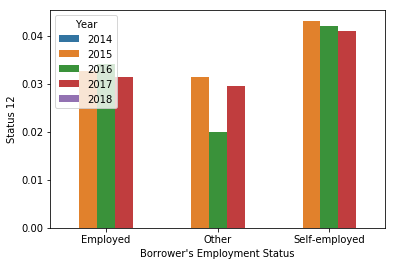

In [18]:
# ACTION: Create dummy data for Self-employed and other and add them to the model parameters
MeanDefault = MergedData[['Year', 'Status 12', 'Status 24','Default24', "Borrower's Employment Status"]].groupby(["Borrower's Employment Status",'Year']).mean().reset_index()
sns.barplot(x="Borrower's Employment Status", y="Status 12",hue="Year",data=MeanDefault)

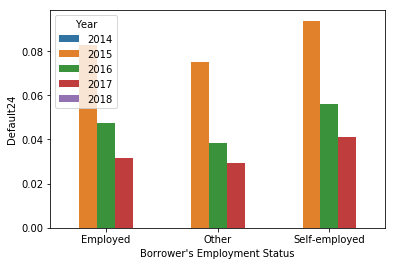

In [19]:
sns.barplot(x="Borrower's Employment Status", y="Default24",hue="Year",data=MeanDefault)

We can see below that as the *Original Term* increases, the proportion of default also increases (although this is less pronounced for the 'Default24' category). We can create bins of 5 and categorise in order to not have too few records in a bucket. We first create a function to categorise Original Term <= 25 as 25 and Original Term >= 70 as 70.

In [47]:
def getTermCategory(x):
    '''
    A function to be used to even out the number of observation within a term bucket in order to see default rates
    within each category.
    x := An element from the 'Original Term' column of the StaticData table.
    Logic: Bucket Original Term <= 25 and >= 70 into their own categories.
    '''
    if x <= 25:
        return 25
    elif x >= 70:
        return 70
    else:
        return x


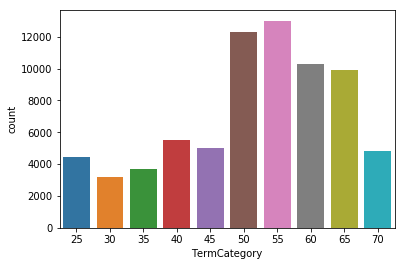

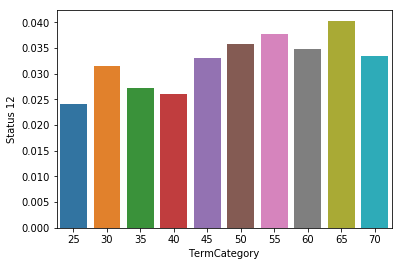

In [21]:
# ACTION: Create Original Term buckets of 5. Group up >= 75 and <=15 into their own categories. 
# Create dummy variables. Then add to the model as a parameter.

# As the term increases, there is a slightly higher chance of default for both 12 and 24 month defaults.
# But this is only true for records with Original Term between 15 and 75 since we don't have enough data otherwise

# We will create buckets of 5
x = MergedData['Original Term'].apply(lambda x: int(x/5)*5)

xdf = pd.DataFrame(x)
xdf['TermCategory'] = xdf['Original Term'].apply(lambda x: getTermCategory(x))

# There are only a small amount of non null records with original term > 70 and < 15 so we omit those
sns.countplot(xdf['TermCategory'])
plt.show()
sns.barplot(x=xdf['TermCategory'], y=MergedData["Status 12"],ci=0)
plt.show()

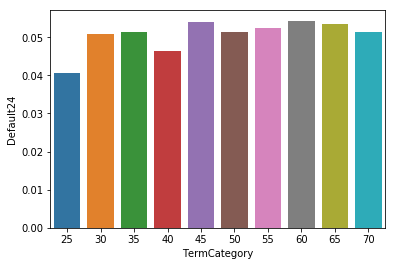

In [22]:
sns.barplot(x=xdf['TermCategory'], y=MergedData["Default24"],ci=0)

APR is on average higher for those that default.

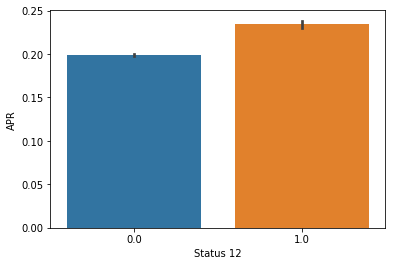

In [23]:
# ACTION: Add APR as a continuous variable to the model

# Those that default have higher APR on average
sns.barplot(x="Status 12", y="APR",data=MergedData)

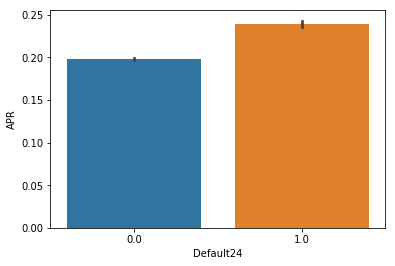

In [24]:
# Those that default have higher APR on average
sns.barplot(x="Default24", y="APR",data=MergedData)

Tier is a good indicator since higher tiers correspond to higher proportion of default for both the 12 month and 24 month periods.

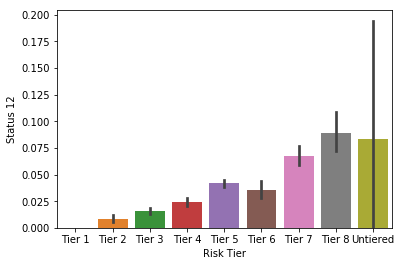

In [25]:
# ACTION: Create dummy indicators for Tier and add it to the model.

# Tier looks to be an indicator
sns.barplot(x="Risk Tier", y="Status 12",data=MergedData,order=['Tier 1','Tier 2','Tier 3','Tier 4','Tier 5','Tier 6','Tier 7','Tier 8','Untiered'])

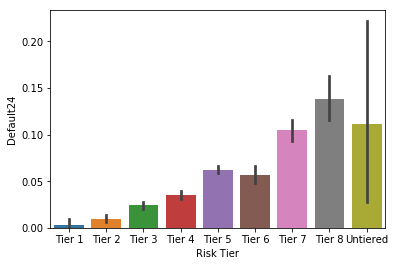

In [26]:
# Tier may be an indicator
sns.barplot(x="Risk Tier", y="Default24",data=MergedData,order=['Tier 1','Tier 2','Tier 3','Tier 4','Tier 5','Tier 6','Tier 7','Tier 8','Untiered'])

LTV seems to be correlated with default proportion. The distribution of LTV is right skewed.

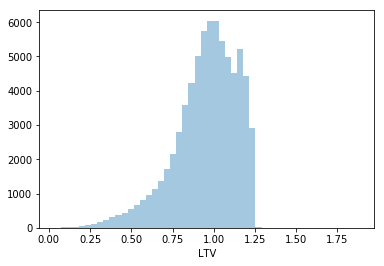

In [27]:
sns.distplot(MergedData["LTV"],kde=False)

In [48]:
def getLTVCategory(x):
    '''
    A function to be used to bucket the LTV to even out observation within each bucket so a default proportion can be observed.
    x := An element in from the LTV column of the StaticData DataFrame.
    Logic: Bucket LTV <= 0.4 and >= 1.2 into their own buckets.
    '''
    if x <= 0.4:
        return 0.4
    elif x >= 1.2:
        return 1.2
    else:
        return round(int(x/0.1)*0.1,2)

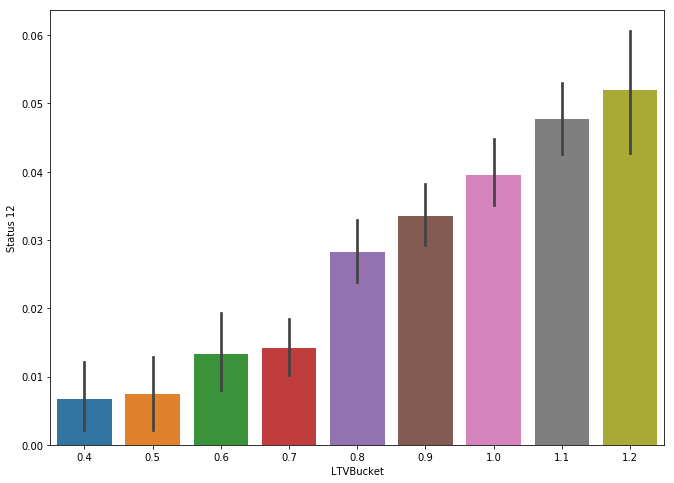

In [29]:
# ACTION: Create LTV buckets. Add this as a numerical feature to the model parameters

MergedData['LTVBucket'] = MergedData['LTV'].apply(getLTVCategory)

fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11, 8)

sns.barplot(x="LTVBucket", y="Status 12",data=MergedData)

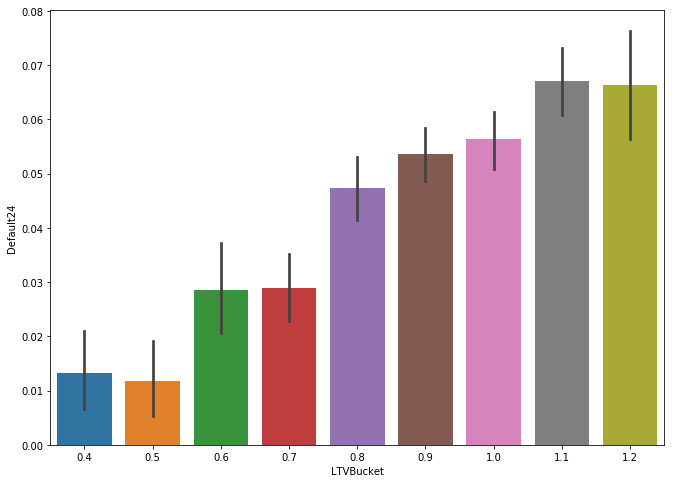

In [30]:
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11, 8)

sns.barplot(x="LTVBucket", y="Default24",data=MergedData)

The *Monthly Instalment* as a percentage of the *Original Loan Size* looks to be related to an increased proportion of defaults.

In [31]:
# ACTION: Create a Monthly Instalment pct column. Bucket these. Then add to the model as a parameter.

MergedData['MonthlyInstalmentpct'] = MergedData[['Original Loan Size','Monthly Instalment']].apply(lambda x: x[1]*100/x[0],axis=1)

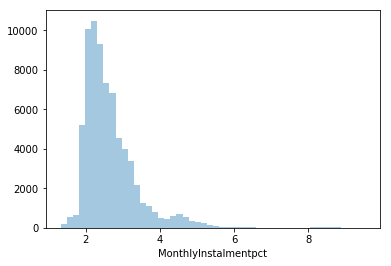

In [32]:
sns.distplot(MergedData["MonthlyInstalmentpct"],kde=False)

In [49]:
def getInstalmentpctCategory(x):
    '''
    A function to be used to bucket the 'Monthly Instalment' to even out observation within each 
    bucket so a default proportion can be observed.
    x := An element in from the 'Monthly Instalment' column of the StaticData DataFrame.
    Logic: Bucket Monthly Instalment <= 1.5 and >= 4 into their own buckets.
    '''
    if x <= 1.5:
        return 1.5
    elif x >= 4:
        return 4
    else:
        return int(x/0.5)*0.5

In [34]:
MergedData['InstalmentpctBucket'] = MergedData['MonthlyInstalmentpct'].apply(getInstalmentpctCategory)

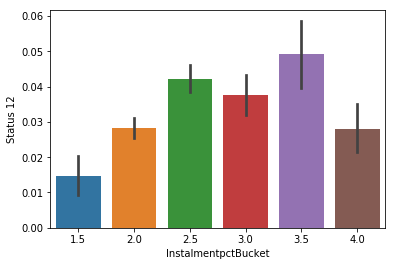

In [35]:
sns.barplot(x="InstalmentpctBucket", y="Status 12",data=MergedData)

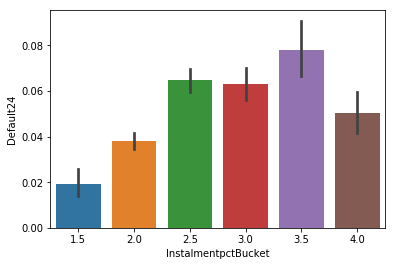

In [36]:
sns.barplot(x="InstalmentpctBucket", y="Default24",data=MergedData)

In [37]:
statusNull122015 = pd.isna(MergedData[(MergedData['Year'] == 2015)]['Status 12']).sum()/len(MergedData[(MergedData['Year'] == 2015)]['Status 12'])
statusNull242015 = pd.isna(MergedData[(MergedData['Year'] == 2015)]['Status 24']).sum()/len(MergedData[(MergedData['Year'] == 2015)]['Status 24'])

print('{} % of the data in 2015 have non-null \'Status 12\' values'.format((1-statusNull122015)*100))
print('{} % of the data in 2015 have non-null \'Status 24\' values\n'.format((1-statusNull242015)*100))



statusNull122016 = pd.isna(MergedData[(MergedData['Year'] == 2016)]['Status 12']).sum()/len(MergedData[(MergedData['Year'] == 2016)]['Status 12'])
statusNull242016 = pd.isna(MergedData[(MergedData['Year'] == 2016)]['Status 24']).sum()/len(MergedData[(MergedData['Year'] == 2016)]['Status 24'])

print('{} % of the data in 2016 have non-null \'Status 12\' values'.format((1-statusNull122016)*100))
print('{} % of the data in 2016 have non-null \'Status 24\' values\n'.format((1-statusNull242016)*100))



statusNull122017 = pd.isna(MergedData[(MergedData['Year'] == 2017)]['Status 12']).sum()/len(MergedData[(MergedData['Year'] == 2017)]['Status 12'])
statusNull242017 = pd.isna(MergedData[(MergedData['Year'] == 2017)]['Status 24']).sum()/len(MergedData[(MergedData['Year'] == 2017)]['Status 24'])

print('{} % of the data in 2017 have non-null \'Status 12\' values'.format((1-statusNull122017)*100))
print('{} % of the data in 2017 have non-null \'Status 24\' values\n'.format((1-statusNull242017)*100))



statusNull122018 = pd.isna(MergedData[(MergedData['Year'] == 2018)]['Status 12']).sum()/len(MergedData[(MergedData['Year'] == 2018)]['Status 12'])
statusNull242018 = pd.isna(MergedData[(MergedData['Year'] == 2018)]['Status 24']).sum()/len(MergedData[(MergedData['Year'] == 2018)]['Status 24'])

print('{} % of the data in 2018 have non-null \'Status 12\' values'.format((1-statusNull122018)*100))
print('{} % of the data in 2018 have non-null \'Status 24\' values'.format((1-statusNull242018)*100))

100.0 % of the data in 2015 have non-null 'Status 12' values
100.0 % of the data in 2015 have non-null 'Status 24' values

100.0 % of the data in 2016 have non-null 'Status 12' values
29.11774039987306 % of the data in 2016 have non-null 'Status 24' values

27.69503664781284 % of the data in 2017 have non-null 'Status 12' values
0.0 % of the data in 2017 have non-null 'Status 24' values

0.0 % of the data in 2018 have non-null 'Status 12' values
0.0 % of the data in 2018 have non-null 'Status 24' values


#### Modelling Value as a function of Loan Rate

We may be able to model the $\textbf{Value=Original Loan Size} \times \textbf{Total Recovery}$ as a function of *Loan Rate* and *Original Term*. Here we are only interested in the consumers that have a non-null *Exposure At Default* because we want to obtain a model for those that have defaulted. We see below that *Value* looks to be a non-linear function of *Loan Rate* and *Total Recovery*. We get a much more linear scatter plot when we use $\textbf{Loan Rate}^2$.

In [38]:
# ACTION: Create a Value column. Add the parameters Loan Rate and Original Term to a Linear Regression model with both mixed effect (synergy effect) and separately

MergedData['Value'] = MergedData['Original Loan Size']*MergedData['Total Recovery']
MergedDataDefaulted12 = MergedData[(MergedData['Status 12'] == 1) & (pd.isna(MergedData['Exposure At Default']).apply(lambda x: not x))]
MergedDataDefaulted24 = MergedData[(MergedData['Default24'] == 1) & (pd.isna(MergedData['Exposure At Default']).apply(lambda x: not x))]

# MergedDataDefaulted12 = MergedData[MergedData['Status 12'] == 1]
# MergedDataDefaulted24 = MergedData[MergedData['Status 24'] == 1]

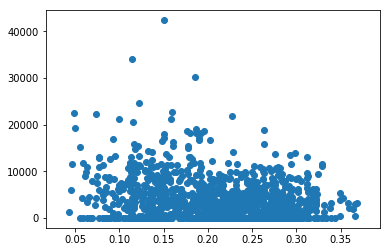

In [39]:
# Let's obtain a relationship with APR
plt.scatter(x=((MergedDataDefaulted12['Loan Rate'])),y=MergedDataDefaulted12['Value'])
#plt.ylim(0,0.05)

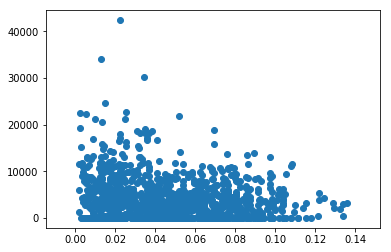

In [40]:
plt.scatter(x=((MergedDataDefaulted12['Loan Rate']**2)),y=MergedDataDefaulted12['Value'])

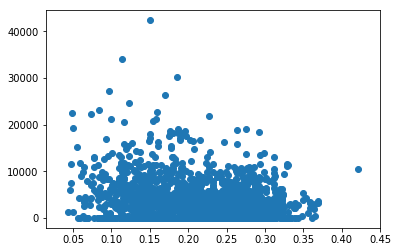

In [41]:
# Let's obtain a relationship with APR
plt.scatter(x=((MergedDataDefaulted24['Loan Rate'])),y=MergedDataDefaulted24['Value'])
#plt.ylim(0,2)

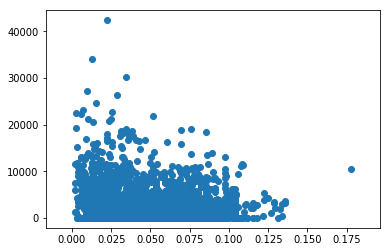

In [42]:
plt.scatter(x=((MergedDataDefaulted24['Loan Rate']**2)),y=MergedDataDefaulted24['Value'])

#### Transformation and Cleaning

Our transform and clean function should have the following actions from our analysis above:

0- ACTION: Merge

1- ACTION: Create new Default24 column and use this instead in the models

2- ACTION: Create dummy data for Self-employed

3- ACTION: Create Original Term buckets of 5. Group up >= 75 and <=15 into their own categories

4- ACTION: Create dummy indicators for Tier

5- ACTION: Create LTV buckets

6- ACTION: Create a Monthly Instalment pct column and bucket them

7- ACTION: Create an Value column

8- ACTION: Create Loan Rate^2 and Loan Rate*OriginalTerm Columns

The Model should have the following parameters:

1- ACTION: Add loan rate to the model parameters

2- ACTION: Add Original Loan Size to the model parameters

3- ACTION: Add dummy data for Employment Status to the model parameters

4- ACTION: Add Term Buckets to model parameters

5- ACTION: Add APR as a continuous variable to the model

6- ACTION: Add dummy data for Term to the model

7- ACTION: Add LTV buckets as a numerical feature to the model parameters

8- ACTION: Add the bucketed Monthly Instalment pct buckets to the model as a parameter

9- ACTION: Add the parameters Loan Rate^2 and Original Term to a Linear Regression model with both mixed effect (synergy effect) and separately in order to model ExposureRatio

In [50]:
def TransformMergeAndCleanData(df,df2):
    '''
    A function used to merge, transform and clean the dataframes according to the above 'ACTIONS' in the analysis. 
    df := The StaticData dataframe
    df2 := The Performance dataframe
    '''
    #0- Merge the two DataFrames
    df_out = df.merge(df2.iloc[:,0:3],on='LoanID')
    
    #1- Create new Default24 column and use this instead in the models
    df_out['Default24'] = df_out[['Status 12','Status 24']].apply(lambda x: default24(x),axis=1)
    
    # Convert the Origination Date to date object
    df_out['OriginationDateFormatted'] = df_out['Origination Date'].apply(lambda x: datetime.datetime.strptime(x.replace('-',''), "%Y%m%d").date())
    
    #2- Employment Status is either Employed, Unemployed or other. Create a series which has entries 0 and 1 specifying whether it's one or the other
    Employment = pd.get_dummies(df_out['Borrower\'s Employment Status'],drop_first=True)
    
    #3- We will create buckets of 5 for Original Term
    x = df_out['Original Term'].apply(lambda x: int(x/5)*5)
    xdf = pd.DataFrame(x)
    OriginalTermBucket = xdf['Original Term'].apply(lambda x: getTermCategory(x))
    OriginalTermBucket.name='OriginalTermBucket'
    
    #4- Create dummy indicators for Tier
    RiskTier = pd.get_dummies(df_out['Risk Tier'],drop_first=True)
    
    #5- Create LTV buckets
    LTVBucket = df_out['LTV'].apply(getLTVCategory)
    LTVBucket.name = 'LTVBucket'
    
    #6- Create a Monthly Instalment pct column and bucket them
    df_out['MonthlyInstalmentpct'] = df_out[['Original Loan Size','Monthly Instalment']].apply(lambda x: x[1]*100/x[0],axis=1)
    df_out['InstalmentpctBucket'] = df_out['MonthlyInstalmentpct'].apply(getInstalmentpctCategory)
    
    #7- Create an ExposureRatio column
    df_out['Value'] = df_out[['Original Loan Size','Total Recovery']].apply(lambda x: x[1]*x[0],axis=1)
    
    #8- Create APR^2 and APR*OriginalTerm Columns
    df_out['LoanRate2'] = df_out['Loan Rate']**2
    df_out['LoanRate2OriginalTerm'] = df_out['LoanRate2']*df_out['Original Term']
    df_out['LoanRateOriginalTerm'] = df_out['Loan Rate']*df_out['Original Term']
    
    Type1 = pd.get_dummies(df['Type 1'],drop_first=True)

    #Concat the series to the data frame
    df_out = pd.concat([df_out,Employment,OriginalTermBucket,RiskTier,LTVBucket,Type1],axis=1)
    
    # Remove records which have null Status 12 and Default24 entries separately
    return df_out[pd.isna(df_out['Status 12']).apply(lambda x: not x)], df_out[pd.isna(df_out['Default24']).apply(lambda x: not x)]

In [54]:
df_final12,df_final24 = TransformMergeAndCleanData(StaticData,Performance)

In [55]:
df_final12.iloc[:,20:].head()

,Status 12,Status 24,Default24,OriginationDateFormatted,MonthlyInstalmentpct,InstalmentpctBucket,Value,LoanRate2,LoanRate2OriginalTerm,LoanRateOriginalTerm,...,Tier 3,Tier 4,Tier 5,Tier 6,Tier 7,Tier 8,Untiered,LTVBucket,B,C
1,0.0,0.0,0.0,2014-12-03,3.230143,3.0,NaN,0.053547,1.820602,7.867685,...,0,0,0,0,0,0,0,0.8,1,0
2,0.0,0.0,0.0,2014-12-16,2.985235,2.5,NaN,0.081245,5.199698,18.242276,...,0,0,1,0,0,0,0,0.9,1,0
3,0.0,0.0,0.0,2014-12-17,3.310211,3.0,NaN,0.059918,2.696304,11.015157,...,0,0,1,0,0,0,0,0.8,0,0
4,0.0,0.0,0.0,2014-12-18,3.342916,3.0,NaN,0.105502,4.536578,13.966849,...,0,0,1,0,0,0,0,0.7,1,0
5,0.0,0.0,0.0,2014-12-22,2.619870,2.5,NaN,0.014856,0.698217,5.728543,...,0,0,0,0,0,0,0,0.9,1,0


In [56]:
# What is our baseline model performance metric?
numDefault12 = len(df_final12[df_final12['Status 12'] == 1])
numDefault24 = len(df_final24[df_final24['Default24'] == 1])

# If we classify all consumers to not default...
base12 = (len(df_final12['Status 12']) - numDefault12)/len(df_final12['Status 12'])
base24 = (len(df_final24['Default24']) - numDefault24)/len(df_final24['Default24'])

print('The base prediction probability for default within 12 months is {}'.format(base12))
print('The base prediction probability for default within 24 months is {}'.format(base24))

The base prediction probability for default within 12 months is 0.9660670966215017
The base prediction probability for default within 24 months is 0.948730844328738


## Regression

#### Logistic Regression

We've seen above that the following metrics may be related to an increase in default probability

1- ACTION: Add loan rate to the model parameters

2- ACTION: Add Original Loan Size to the model parameters

3- ACTION: Add dummy data for Employment Status to the model parameters

4- ACTION: Add Term Buckets to model parameters

5- ACTION: Add APR as a continuous variable to the model

6- ACTION: Add dummy data for Risk Tier to the model

7- ACTION: Add LTV buckets as a numerical feature to the model parameters

8- ACTION: Add the bucketed Monthly Instalment pct buckets to the model as a parameter

9- ACTION: Add the parameters Loan Rate^2 and Original Term to a Linear Regression model with both mixed effect (synergy effect) and separately in order to model ExposureRatio

In [57]:
df_final12.columns

Index(['Year', 'LoanID', 'Original Loan Size', 'Origination Date',
       'Original Term', 'APR', 'Loan Rate', 'LTV', 'Monthly Instalment',
       'Type 1', 'Type 2', 'Borrower's Employment Status', 'Risk Tier',
       'Exposure At Default', 'Further Recovery Expected Y/N',
       'Recoveries @ 6m', 'Recoveries @ 9m', 'Recoveries @ 12m',
       'Total Recovery', 'Prepayment Amount', 'Status 12', 'Status 24',
       'Default24', 'OriginationDateFormatted', 'MonthlyInstalmentpct',
       'InstalmentpctBucket', 'Value', 'LoanRate2', 'LoanRate2OriginalTerm',
       'LoanRateOriginalTerm', 'Other', 'Self-employed', 'OriginalTermBucket',
       'Tier 2', 'Tier 3', 'Tier 4', 'Tier 5', 'Tier 6', 'Tier 7', 'Tier 8',
       'Untiered', 'LTVBucket', 'B', 'C'],
      dtype='object')

Select the parameters we're interested in

In [58]:
X = df_final12.reset_index()[['Loan Rate','Original Loan Size','APR',\
                              'Tier 2','Tier 3','Tier 4','Tier 5', 'Tier 6', 'Tier 7', 'Tier 8','Untiered',\
                             'Self-employed','Other','OriginalTermBucket','LTVBucket','MonthlyInstalmentpct']]
y = df_final12.reset_index()['Status 12']

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Fit the Logistic Regression model

In [59]:
lr12 = LogisticRegression()
lr12.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

The coefficients of the model are

In [60]:
print(lr12.coef_)
print(lr12.intercept_)

def Predict(df,classifier):
    return np.array(list(map(lambda x: 1 if x[0] > 0.97855 else False ,classifier.predict_proba(df))))

[[ 9.17115907e-02  3.22972981e-05  1.02360811e-01 -2.75324848e-01
  -4.14412089e-01 -2.62427364e-01  1.68466536e-01  3.42045678e-02
   3.28763903e-01  1.80046405e-01  5.90607346e-03  4.58641885e-02
  -4.04154531e-02 -4.42518192e-02  2.39569818e-02 -4.08082349e-01]]
[-0.28164634]


Predictions

In [61]:
predictions = lr12.predict(X)
#predictions = Predict(X_test,lr)

In [62]:
print(classification_report(y,predictions))
print(confusion_matrix(y,predictions))
print(accuracy_score(y,predictions))

             precision    recall  f1-score   support

        0.0       0.97      1.00      0.98     32655
        1.0       0.00      0.00      0.00      1147

avg / total       0.93      0.97      0.95     33802

[[32655     0]
 [ 1147     0]]
0.9660670966215017


C:\Users\HVAD\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


At this point we can use the predictions from the fitted model to get the probability distribution of the test data set. We see that the probability distribution of the test dataset is left skewed. This probability distribution is for the probability of default and as expected, defaulting is a rare event.

The mean of this distribution is 0.03694186308347415
The median of this distribution is 0.034
The IQR of this distribution is 0.019


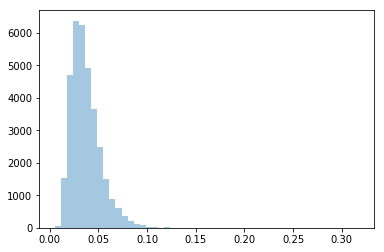

In [63]:
# Probability distribution of default for the dataset
sns.distplot(lr12.predict_proba(X)[:,1],kde=False)
print('The mean of this distribution is {}'.format(np.mean(lr12.predict_proba(X)[:,1])))

a = list(map(lambda x: round(x,3),lr12.predict_proba(X)[:,1]))
print('The median of this distribution is {}'.format(statistics.median(a)))

print('The IQR of this distribution is {}'.format(stats.iqr(a,rng=(25,75))))

We can then calculate the default probability of the consumers with the following profiles (person1 has in fact defaulted within the 12 month period but person2 hasn't). The main differences between these two consumers is the Tier and Loan Rate. Consumer1 is in Tier 5 whereas consumer2 is in Tier 3.

In [64]:
person1 = df_final12[['Loan Rate','Original Loan Size','APR',\
                              'Tier 2','Tier 3','Tier 4','Tier 5', 'Tier 6', 'Tier 7', 'Tier 8','Untiered',\
                             'Self-employed','Other','OriginalTermBucket','LTVBucket','MonthlyInstalmentpct']].iloc[42,0:]

person2 = df_final12[['Loan Rate','Original Loan Size','APR',\
                              'Tier 2','Tier 3','Tier 4','Tier 5', 'Tier 6', 'Tier 7', 'Tier 8','Untiered',\
                             'Self-employed','Other','OriginalTermBucket','LTVBucket','MonthlyInstalmentpct']].iloc[38,0:]

In [65]:
print('Consumer1\n',person1,'\n\n','Consumer2\n',person2)


Consumer1
 Loan Rate                  0.173690
Original Loan Size      2441.177116
APR                        0.241542
Tier 2                     0.000000
Tier 3                     0.000000
Tier 4                     0.000000
Tier 5                     1.000000
Tier 6                     0.000000
Tier 7                     0.000000
Tier 8                     0.000000
Untiered                   0.000000
Self-employed              0.000000
Other                      0.000000
OriginalTermBucket        35.000000
LTVBucket                  1.000000
MonthlyInstalmentpct       3.586794
Name: 43, dtype: float64 

 Consumer2
 Loan Rate                  0.076448
Original Loan Size      2528.296369
APR                        0.165869
Tier 2                     0.000000
Tier 3                     1.000000
Tier 4                     0.000000
Tier 5                     0.000000
Tier 6                     0.000000
Tier 7                     0.000000
Tier 8                     0.000000
Untiered      

The fitted logistic regression model has the following form:

$$logOdds = \ln (\frac{P(D)}{1-P(D)}) = \beta_0 + \beta_1 X_1 + ... + \beta_n X_n$$

By taking the exponential of both sides of this equation we can retrieve the probability of default (D):

$$P(D) = \frac{\exp(\beta_0 + \beta_1 X_1 + ... + \beta_n X_n)}{1+\exp(\beta_0 + \beta_1 X_1 + ... + \beta_n X_n)}$$

Programmatically, this is as follows:

In [66]:
logprob = lr12.intercept_[0]
for i in range(0,16):
    logprob += lr12.coef_[0][i]*person1[i]
print('Person1 has a default probability of {}'.format((math.e**logprob)/(1+math.e**logprob)))

logprob = lr12.intercept_[0]
for i in range(0,16):
    logprob += lr12.coef_[0][i]*person2[i]
print('Person2 has a default probability of {}'.format((math.e**logprob)/(1+math.e**logprob)))

Person1 has a default probability of 0.04823438301224962
Person2 has a default probability of 0.020229806521631314


We can utilise the *predict_proba* method of the *Logistic Regression* object in order to get these values as well:

In [67]:
person1 = person1.values.reshape(1,-1)
person2 = person2.values.reshape(1,-1)

In [68]:
print('Default probability of Consumer1 = {}'.format(lr12.predict_proba(person1)[0][1]))
print('Default probability of Consumer2 = {}'.format(lr12.predict_proba(person2)[0][1]))

Default probability of Consumer1 = 0.04823438301224961
Default probability of Consumer2 = 0.020229806521631307


We do the same for the probability of default within the first 24 months

[[ 9.17115907e-02  3.22972981e-05  1.02360811e-01 -2.75324848e-01
  -4.14412089e-01 -2.62427364e-01  1.68466536e-01  3.42045678e-02
   3.28763903e-01  1.80046405e-01  5.90607346e-03  4.58641885e-02
  -4.04154531e-02 -4.42518192e-02  2.39569818e-02 -4.08082349e-01]]
[-0.28164634]
             precision    recall  f1-score   support

        0.0       0.95      1.00      0.97     32069
        1.0       0.00      0.00      0.00      1733

avg / total       0.90      0.95      0.92     33802

[[32069     0]
 [ 1733     0]]
0.948730844328738
The mean of this distribution is 0.054449257077137304


C:\Users\HVAD\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The median of this distribution is 0.053
The IQR of this distribution is 0.021000000000000005
Default probability of Consumer1 = 0.06246069916346353
Default probability of Consumer2 = 0.0448581386857925


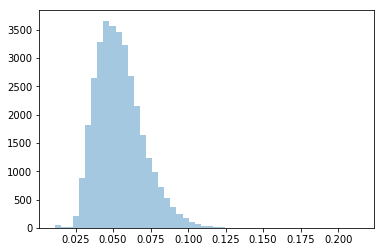

In [69]:
y = df_final12.reset_index()['Default24']
lr24 = LogisticRegression()
lr24.fit(X,y)
print(lr12.coef_)
print(lr12.intercept_)
predictions = lr24.predict(X)
print(classification_report(y,predictions))
print(confusion_matrix(y,predictions))
print(accuracy_score(y,predictions))

# Probability distribution of default for the dataset
sns.distplot(lr24.predict_proba(X)[:,1],kde=False)
print('The mean of this distribution is {}'.format(np.mean(lr24.predict_proba(X)[:,1])))

a = list(map(lambda x: round(x,3),lr24.predict_proba(X)[:,1]))
print('The median of this distribution is {}'.format(statistics.median(a)))

print('The IQR of this distribution is {}'.format(stats.iqr(a,rng=(25,75))))

print('Default probability of Consumer1 = {}'.format(lr24.predict_proba(person1)[0][1]))
print('Default probability of Consumer2 = {}'.format(lr24.predict_proba(person2)[0][1]))

These probabilities puts Consumer1 in to the riskier part of the distribution (i.e. a riskier consumer within the population) and Consumer2 into the safer consumer (i.e. less then median of the distribution). As expected, the probability of default within the first 24 months is greater than that for the first 12 months.

This is how we interpret the above probabilities given the definitions of the transformed columns:

$$D_{24} \cup D_{12} = D_{24}$$

$$D_{24} \cap D_{12} = D_{12}$$

$$D_{24} \cap D_{12}^c = D_{24}$$

$$D_{24} = \{D_{24} \cap D_{12}^c\} \cup \{ D_{24} \cap D_{12} \}$$

$\{D_{24} \cap D_{12}^c\}$ and $ \{ D_{24} \cap D_{12} \}$ partition the universal set and since $D_{12} \subseteq D_{24}$, $ \{D_{24} \cap D_{12}^c\} = \{D_{24} / D_{12}\} $ and $ \{ D_{24} \cap D_{12} \} = D_{12}$

So,

$$P(D_{24}) = P(D_{24}/D_{12}) + P(D_{12}) \implies P(D_{24}/D_{12}) = P(D_{24}) - P(D_{12})$$

We will need this result when we want to calculate the value (how much we have salvaged) of a consumer loan based on how much recovery a consumer as achieved given that they have defaulted.

Now let's model the *Value* from all those that have defaulted.

#### Linear Regression

In [75]:
temp = df_final12[pd.isna(df_final12['Exposure At Default']).apply(lambda x: not x)].\
reset_index()[['Loan Rate','LoanRate2','Original Term','LoanRate2OriginalTerm','LoanRateOriginalTerm','Value','Tier 2','Tier 3',\
               'Tier 4','Tier 5', 'Tier 6', 'Tier 7', 'Tier 8','Untiered','OriginalTermBucket','Total Recovery']]
#temp = temp[(temp['Original Term'] <= 71)]

X = temp[['Loan Rate','LoanRate2','LoanRateOriginalTerm','LoanRate2OriginalTerm']]
y = temp['Value']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [76]:
lm = LinearRegression()
lm.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [77]:
print('Value = {} + {} LR + {} LR^2 + {} LR * OT + {} LR^2 * OT'.format(lm.intercept_,lm.coef_[0],lm.coef_[1],lm.coef_[2],lm.coef_[3]))

Value = 6506.539994099194 + -65482.482566579216 LR + 155813.8648940269 LR^2 + 810.2869754252193 LR * OT + -2292.073807838436 LR^2 * OT


In [78]:
predictions = lm.predict(X)

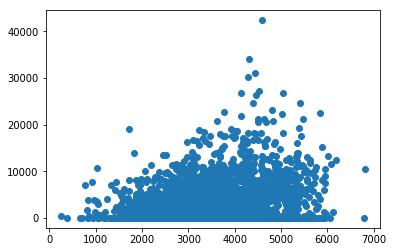

In [79]:
plt.scatter(x=predictions,y=y)

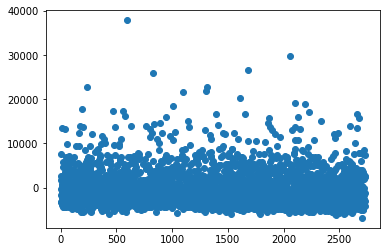

In [80]:
residuals = y - predictions
#sns.distplot(residuals)
plt.scatter(np.arange(0,len(residuals)),residuals)

In [82]:
temp = df_final12[pd.isna(df_final12['Exposure At Default']).apply(lambda x: not x)].\
reset_index()[['Loan Rate','LoanRate2','Original Term','LoanRate2OriginalTerm','LoanRateOriginalTerm','Value','Tier 2','Tier 3',\
               'Tier 4','Tier 5', 'Tier 6', 'Tier 7', 'Tier 8','Untiered','OriginalTermBucket','Total Recovery']]
#temp = temp[temp['Original Term'] <= 71]

X = temp[['Loan Rate','LoanRate2','LoanRateOriginalTerm','LoanRate2OriginalTerm']]
y = temp['Value']


# X['logAPR'] = X['APR'].apply(math.log)
# X['logAPROT'] = X['logAPR']*X['Original Term']
# X['APR3'] = X['APR']**3
# X['APR3OT'] = X['APR3']**X['Original Term']

# # Normalise
# X['APR'] = X['APR']/max(X['APR'])
# X['APR2'] = X['APR2']/max(X['APR2'])
# X['Original Term'] = X['Original Term']/max(X['Original Term'])
# X['APR2OriginalTerm'] = X['APR2OriginalTerm']/max(X['APR2OriginalTerm'])
# X['APR3'] = X['APR3']/max(X['APR3'])
# X['APR3OT'] = X['APR3OT']/max(X['APR3OT'])


X_new = sm.add_constant(X)
est = sm.OLS(y, X_new)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  Value   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     39.48
Date:                Sat, 13 Oct 2018   Prob (F-statistic):           3.48e-32
Time:                        12:11:13   Log-Likelihood:                -26661.
No. Observations:                2733   AIC:                         5.333e+04
Df Residuals:                    2728   BIC:                         5.336e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  6506.54

Here we have obtained the following equation relating Loan Rate (LR), Original Term (OT), Original Loan Size (OS) and Total Recovery (TR):

$$\text{Value} = OS \times TR = 6506.54 + (810.287 \times OT - 65480) \times LR - (155900 - 2292 \times OT) \times LR^2$$

It should be noted that for values of OT within the range $[0,68]$, this gives a concave quadratic equation in LR. 

## Linear Discriminant Analysis

In [710]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [711]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train,y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [716]:
predictions = lda.predict(X_test)

In [717]:
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))
print(accuracy_score(y_test,predictions))

             precision    recall  f1-score   support

        0.0       0.97      1.00      0.98      9810
        1.0       0.00      0.00      0.00       331

avg / total       0.94      0.97      0.95     10141

[[9801    9]
 [ 331    0]]
0.9664727344443349


In [718]:
lda.predict_proba(person)

array([[0.98472086, 0.01527914]])

## General

In [1407]:
import sklearn as skl
from sklearn import gaussian_process
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [1408]:
X = df_final12[['Other','Self-employed','Original Loan Size']]
y = df_final12['Status 12']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [1409]:
ML = [
    skl.ensemble.ExtraTreesClassifier(),
    skl.ensemble.BaggingClassifier(),
    LinearSVC()
    #gaussian_process.GaussianProcessClassifier(),
    #XGBClassifier()
]

In [1410]:
ML[2].fit(X_train,y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [1411]:
predictions = ML[2].predict(X_test)

In [1412]:
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))
print(accuracy_score(y_test,predictions))

             precision    recall  f1-score   support

        0.0       0.97      1.00      0.98      9810
        1.0       0.00      0.00      0.00       331

avg / total       0.94      0.97      0.95     10141

[[9810    0]
 [ 331    0]]
0.9673602208855142


C:\Users\HVAD\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Going Further

We might like to know how risky it is in a monetary sense to embark on a loan arrangement with a counterparty which has a certain default probability. In order to come to a conclusion, we can factor in the amount that is at risk (Original Loan Size := OLS), the default risk ($P(D_{12})$), the Original Term (OT), the Loan rate (LR) offered (though this should be a function of the risk itself but here we take it as a given) and the Total Recovery percentage (TR). 

i.e. we want to calculate the Value given that this person defaults multiplied by the probability of this person defaulting. This is Expected Value (EV):

$$EV = P(D_{12}|\theta,OLS,OT,LR)*(Value | D_{12}) + P(D_{12}^c | \theta,OLS,OT,LR) * (Value | D_{12}^c)$$
$$ = P(D_{12}|\theta,OLS,OT,LR)*(Value | D_{12}) + (1 - P(D_{12} | \theta,OLS,OT,LR)) * (OLS*LR)$$

In the above equation, $P(D_{12})$ is the default probability within 12 months, $P(D_{12}^c)=1-P(D_{12})$, and $\theta$ represents all the other variables we have used in our model to predict default probability. 

Even though OT, LR and OLS are expected to be related variables, below we can fix a value for OT and OLS and see what we can expect the shape of the EV curve to look like:

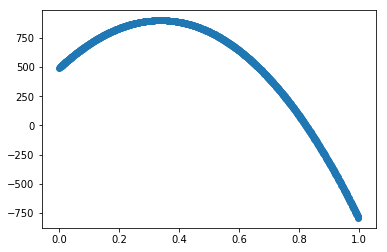

In [441]:
OT = 50
OLS = 5000

# Let LR range from 0 to 1000
LR = np.arange(0,1000)*(1/1000)

# We use our linear regression fitted values
Value = 6506.54 + (810.287 * OT - 65500) * LR - (156000 - 2292 * OT) * LR**2

# This is the default probability within 12 months (i.e. an exponential function)
a = lr12.intercept_ + lr12.coef_[0][0] * LR + lr12.coef_[0][13] * OT
ProbDefault12 = np.array(list(map(lambda x: math.exp(x)/(1+math.exp(x)),a)))

# The total value is then the an function of default and the value given default
totValue = (1-ProbDefault12)*OLS*LR + ProbDefault12*(Value - OLS*LR)

plt.scatter(x=LR,y=totValue)

In this case, we may offer a loan rate of around 0.35 for this person.

Using the models we have derived, we can come up with an offer for Person1 and Person2:

In [176]:
person1 = df_final12[['Loan Rate','Original Loan Size','APR',\
                              'Tier 2','Tier 3','Tier 4','Tier 5', 'Tier 6', 'Tier 7', 'Tier 8','Untiered',\
                             'Self-employed','Other','OriginalTermBucket','LTVBucket','MonthlyInstalmentpct']].iloc[42,0:]

person2 = df_final12[['Loan Rate','Original Loan Size','APR',\
                              'Tier 2','Tier 3','Tier 4','Tier 5', 'Tier 6', 'Tier 7', 'Tier 8','Untiered',\
                             'Self-employed','Other','OriginalTermBucket','LTVBucket','MonthlyInstalmentpct']].iloc[38,0:]

print('Consumer1\n',person1,'\n\n','Consumer2\n',person2)

Consumer1
 Loan Rate                  0.173690
Original Loan Size      2441.177116
APR                        0.241542
Tier 2                     0.000000
Tier 3                     0.000000
Tier 4                     0.000000
Tier 5                     1.000000
Tier 6                     0.000000
Tier 7                     0.000000
Tier 8                     0.000000
Untiered                   0.000000
Self-employed              0.000000
Other                      0.000000
OriginalTermBucket        35.000000
LTVBucket                  1.000000
MonthlyInstalmentpct       3.586794
Name: 43, dtype: float64 

 Consumer2
 Loan Rate                  0.076448
Original Loan Size      2528.296369
APR                        0.165869
Tier 2                     0.000000
Tier 3                     1.000000
Tier 4                     0.000000
Tier 5                     0.000000
Tier 6                     0.000000
Tier 7                     0.000000
Tier 8                     0.000000
Untiered      

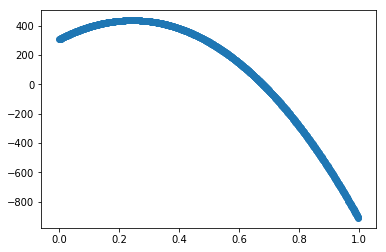

In [274]:
# Let LR range from 0 to 1000
LR = np.arange(0,1000)*(1/1000)

DummyConsumers = []

for i in range(0,len(LR)):
    persontemp = []
    persontemp.append(LR[i])
    for j in range(1,16):
        persontemp.append(person1[j])
    DummyConsumers.append(persontemp)

# Probability of default within 12 months of person1 as a function of loan rate
prob1 = lr12.predict_proba(DummyConsumers)[:,1]

OLS = person1['Original Loan Size']
OT = person1['OriginalTermBucket']

# The total value is then the an function of default and the value given default
totValue = (1-prob1)*OLS*LR + prob1*(Value - OLS*LR)

plt.scatter(x=LR,y=totValue)

The best Loan Rate for person1 is therefore around 0.3. However, this consumer was given a Loan Rate of 0.17

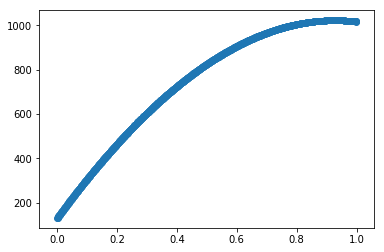

In [275]:
# Let LR range from 0 to 1000
LR = np.arange(0,1000)*(1/1000)

DummyConsumers = []

for i in range(0,len(LR)):
    persontemp = []
    persontemp.append(LR[i])
    for j in range(1,16):
        persontemp.append(person2[j])
    DummyConsumers.append(persontemp)

# Probability of default within 12 months of person1 as a function of loan rate
prob1 = lr12.predict_proba(DummyConsumers)[:,1]

OLS = person1['Original Loan Size']
OT = person1['OriginalTermBucket']

# The total value is then the an function of default and the value given default
totValue = (1-prob1)*OLS*LR + prob1*(Value - OLS*LR)

plt.scatter(x=LR,y=totValue)

As seen before, person2 is much less risky, as a result we are able to give a much larger Loan Rate (around 0.9) in order to maximise our returns. 

It must be said that less risky individuals are offered lower Loan Rates in general contrary to what we have just seen. The reason is that there exists a hypothetical function of customer satisfaction and industry competition. In the above example with person2, we cannot entice this consumer with a Loan Rate of 0.9, since the market can offer a better rate and still make a return. So in order to make use of the above model, we would need a penalty function dependent on customer satisfaction and a penalty function for administration work. This would also explain why the consumers were offered a lower rate than the optimum for the lender.

Once this has been incorporated in the form of customer churn, it may be possible to contact the customer to offer a better rate if this would off-set the penalty due to customer churn, i.e. we are offering a better rate in order to reduce the probability of losing this customer and therefore losing the return we would have made if we offered a slightly lower Loan Rate. 

In [351]:
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn import naive_bayes
from sklearn.ensemble import RandomForestClassifier

In [429]:
tempdf = df_final12

X = df_final12.reset_index()[['Loan Rate','Original Loan Size','APR',\
                              'Tier 2','Tier 3','Tier 4','Tier 5', 'Tier 6', 'Tier 7', 'Tier 8','Untiered',\
                             'Self-employed','Other','OriginalTermBucket','LTVBucket','MonthlyInstalmentpct']]
y = df_final12.reset_index()['Status 12']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

kn = RandomForestClassifier(n_estimators=200)
kn.fit(X_train,y_train)
predictions = kn.predict(X_test)

print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))
print(accuracy_score(y_test,predictions))

             precision    recall  f1-score   support

        0.0       0.97      1.00      0.98     10784
        1.0       0.00      0.00      0.00       371

avg / total       0.93      0.97      0.95     11155

[[10784     0]
 [  371     0]]
0.9667413715822502


C:\Users\HVAD\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [440]:
kn.predict_proba(person2.reshape(1,-1))

C:\Users\HVAD\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.


array([[1., 0.]])

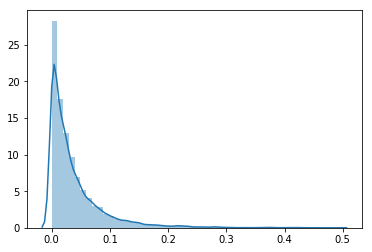

In [436]:
sns.distplot(kn.predict_proba(X_test)[:,1])

In [349]:
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))
print(accuracy_score(y_test,predictions))

             precision    recall  f1-score   support

        0.0       0.95      1.00      0.97     10577
        1.0       0.00      0.00      0.00       578

avg / total       0.90      0.95      0.92     11155

[[10577     0]
 [  578     0]]
0.9481846705513223


C:\Users\HVAD\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
